In [1]:
import os
from pathlib import Path
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
from pyspark.sql import SparkSession
from pyspark.sql import dataframe as spark_df
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, StringType, StructField, StructType
from pyspark.sql.window import Window, WindowSpec

## Spark Session

In [3]:
spark: SparkSession = (
    SparkSession.builder.appName("window_functions").master("local[*]").getOrCreate()
)

spark.sparkContext.setLogLevel("ERROR")

spark.sparkContext

<SparkContext master=local[*] appName=window_functions>

In [4]:
pd.set_option("mode.copy_on_write", True)

## Data

In [5]:
data_path: str = str(Path(os.getcwd()).parent / "data" / "gsod")

gsod = spark.read.parquet(data_path)
gsod_pl = pl.scan_parquet(str(Path(data_path) / "*.parquet"))
gsod_pd = pd.read_parquet(data_path)

gsod.count(), len(gsod.columns)

(12460217, 32)

In [14]:
gsod.printSchema()

root
 |-- stn: string (nullable = true)
 |-- wban: string (nullable = true)
 |-- year: string (nullable = true)
 |-- mo: string (nullable = true)
 |-- da: string (nullable = true)
 |-- temp: double (nullable = true)
 |-- count_temp: long (nullable = true)
 |-- dewp: double (nullable = true)
 |-- count_dewp: long (nullable = true)
 |-- slp: double (nullable = true)
 |-- count_slp: long (nullable = true)
 |-- stp: double (nullable = true)
 |-- count_stp: long (nullable = true)
 |-- visib: double (nullable = true)
 |-- count_visib: long (nullable = true)
 |-- wdsp: string (nullable = true)
 |-- count_wdsp: string (nullable = true)
 |-- mxpsd: string (nullable = true)
 |-- gust: double (nullable = true)
 |-- max: double (nullable = true)
 |-- flag_max: string (nullable = true)
 |-- min: double (nullable = true)
 |-- flag_min: string (nullable = true)
 |-- prcp: double (nullable = true)
 |-- flag_prcp: string (nullable = true)
 |-- sndp: double (nullable = true)
 |-- fog: string (nullable =

In [19]:
gsod.show()

+------+-----+----+---+---+-----+----------+------+----------+------+---------+------+---------+-----+-----------+----+----------+-----+-----+-----+--------+------+--------+----+---------+-----+---+------------+----------------+----+-------+--------------------+
|   stn| wban|year| mo| da| temp|count_temp|  dewp|count_dewp|   slp|count_slp|   stp|count_stp|visib|count_visib|wdsp|count_wdsp|mxpsd| gust|  max|flag_max|   min|flag_min|prcp|flag_prcp| sndp|fog|rain_drizzle|snow_ice_pellets|hail|thunder|tornado_funnel_cloud|
+------+-----+----+---+---+-----+----------+------+----------+------+---------+------+---------+-----+-----------+----+----------+-----+-----+-----+--------+------+--------+----+---------+-----+---+------------+----------------+----+-------+--------------------+
|998258|99999|2017| 03| 08| 32.9|        11|9999.9|         0|1009.2|       11|9999.9|        0|999.9|          0| 5.6|        11| 13.0|999.9| 35.6|       *|  30.7|       *| 0.0|        I|999.9|  0|           0|

## Coldest Day of Each Year

### Using Joins

<div style="text-align: center;">
    <img src="../diagrams/left_semi_join.png" width="50%" alt="Left Semi Join Diagram">
    <p><strong>Source:</strong> <a href="https://www.manning.com/books/data-analysis-with-python-and-pyspark" target="_blank">Data Analysis with Python and PySpark – Chapter 10</a></p>
</div>

#### Pyspark

In [9]:
coldest_temp: spark_df.DataFrame = (
    gsod.groupby("year")
    .agg(F.min("temp").alias("temp"))
    .orderBy("temp", ascending=False)
)

coldest_temp.show()

+----+------+
|year|  temp|
+----+------+
|2018|-113.5|
|2017|-114.7|
|2019|-114.7|
+----+------+



In [10]:
coldest_when: spark_df.DataFrame = (
    gsod.join(
        other=coldest_temp,
        on=["year", "temp"],
        how="left_semi",
    )
    .select("stn", "year", "mo", "da", "temp")
    .orderBy(
        ["year", "mo", "da"],
    )
)

coldest_when.toPandas()

,stn,year,mo,da,temp
0,896250,2017,06,20,-114.7
1,896060,2018,08,27,-113.5
2,895770,2019,06,15,-114.7


#### Polars

In [69]:
coldest_temp_pl: pl.LazyFrame = (
    gsod_pl.group_by(pl.col(["year"]))
    .agg(pl.min("temp"))
    .sort(by=pl.col(["temp"]), descending=True)
)

coldest_temp_pl.collect()

year,temp
str,f64
"""2018""",-113.5
"""2017""",-114.7
"""2019""",-114.7


In [70]:
coldest_when_pl: pl.LazyFrame = (
    gsod_pl.join(other=coldest_temp_pl, on=["year", "temp"], how="semi")
    .select(pl.col(["stn", "year", "mo", "da", "temp"]))
    .sort(by=["year", "mo", "da"])
)

coldest_when_pl.collect()

stn,year,mo,da,temp
str,str,str,str,f64
"""896250""","""2017""","""06""","""20""",-114.7
"""896060""","""2018""","""08""","""27""",-113.5
"""895770""","""2019""","""06""","""15""",-114.7


#### Pandas

In [75]:
coldest_temp_pd: pd.DataFrame = (
    gsod_pd.groupby(by=["year"])
    .agg({"temp": "min"})
    .sort_values(by=["temp"], ascending=False)
    .reset_index()
)

coldest_temp_pd

,year,temp
0,2018,-113.5
1,2017,-114.7
2,2019,-114.7


In [76]:
coldest_when_pd: pd.DataFrame = pd.merge(
    left=gsod_pd.loc[:, ["stn", "year", "mo", "da", "temp"]],
    right=coldest_temp_pd,
    on=["year", "temp"],
    how="inner",
).sort_values(by=["year", "mo", "da"])

coldest_when_pd

,stn,year,mo,da,temp
0,896250,2017,06,20,-114.7
1,896060,2018,08,27,-113.5
2,895770,2019,06,15,-114.7


### Using Window Functions

#### Pyspark

In [6]:
year_window: WindowSpec = Window.partitionBy("year")

year_window

In [7]:
coldest_when: spark_df.DataFrame = (
    gsod.withColumn(
        colName="min_temp", col=F.min(F.col("temp")).over(window=year_window)
    )
    .where(F.col("temp") == F.col("min_temp"))
    .select(["stn", "year", "mo", "da", "temp"])
    .orderBy(["year", "mo", "da"])
)

coldest_when.toPandas()

,stn,year,mo,da,temp
0,896250,2017,06,20,-114.7
1,896060,2018,08,27,-113.5
2,895770,2019,06,15,-114.7


#### Polars

In [93]:
coldest_when_pl: pl.LazyFrame = (
    gsod_pl.with_columns(
        pl.col("temp").min().over(partition_by=[pl.col("year")]).alias("min_temp")
    )
    .filter(pl.col("temp") == pl.col("min_temp"))
    .select(["stn", "year", "mo", "da", "temp"])
    .sort(by=["year", "mo", "da"])
)

coldest_when_pl.collect()

stn,year,mo,da,temp
str,str,str,str,f64
"""896250""","""2017""","""06""","""20""",-114.7
"""896060""","""2018""","""08""","""27""",-113.5
"""895770""","""2019""","""06""","""15""",-114.7


#### Pandas

In [97]:
coldest_when_pd: pd.DataFrame = (
    gsod_pd.assign(min_temp=lambda x: x.groupby(by="year")["temp"].transform("min"))
    .query("temp == min_temp")
    .loc[:, ["stn", "year", "mo", "da", "temp"]]
    .sort_values(by=["year", "mo", "da"])
    .reset_index(drop=True)
)

coldest_when_pd

,stn,year,mo,da,temp
0,896250,2017,06,20,-114.7
1,896060,2018,08,27,-113.5
2,895770,2019,06,15,-114.7


## Hottest Station On Each Day

### Pyspark

In [116]:
window_by_year_month_day: WindowSpec = Window.partitionBy(["year", "mo", "da"])

hottest_station_by_day: spark_df.DataFrame = (
    gsod.withColumn(
        colName="max_temp", col=F.max("temp").over(window=window_by_year_month_day)
    )
    .where(F.col("temp") == F.col("max_temp"))
    .select(["stn", "year", "mo", "da", "temp"])
    .orderBy(["year", "mo", "da"])
)

hottest_station_by_day.count()

1135

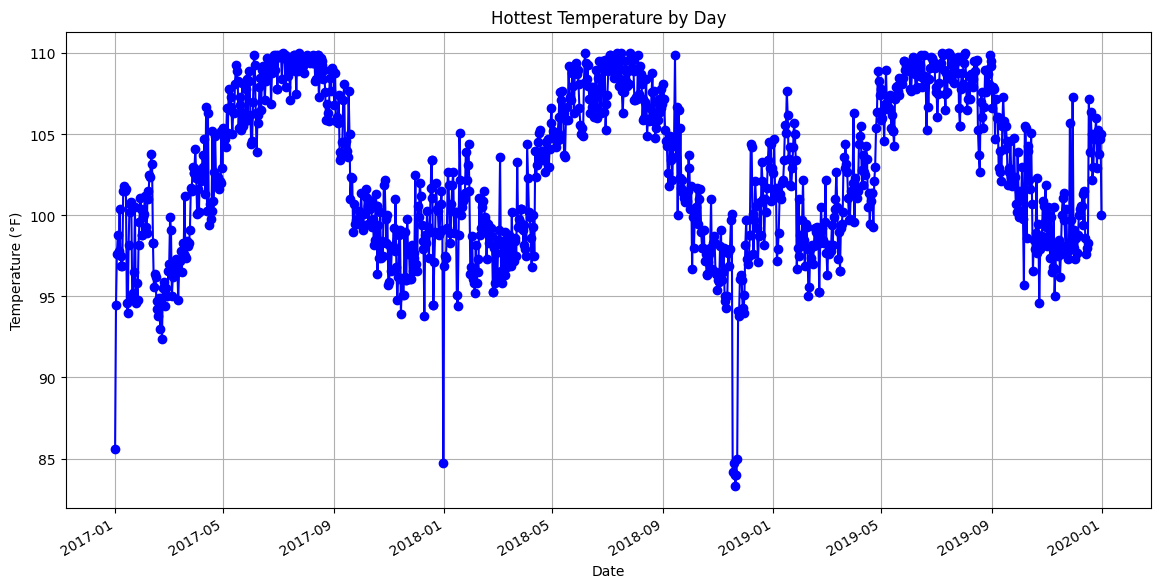

In [129]:
hottest_station_by_day_pd: pd.DataFrame = hottest_station_by_day.toPandas()

hottest_station_by_day_pd["date"] = pd.to_datetime(
    hottest_station_by_day_pd[["year", "mo", "da"]].rename(
        columns={"mo": "month", "da": "day"}
    )
)

hottest_station_by_day_pd = hottest_station_by_day_pd.sort_values(
    by="date", ascending=True
)

plt.figure(figsize=(14, 7))
plt.plot(
    hottest_station_by_day_pd["date"],
    hottest_station_by_day_pd["temp"],
    marker="o",
    linestyle="-",
    color="blue",
)

plt.title("Hottest Temperature by Day")
plt.xlabel("Date")
plt.ylabel("Temperature (°F)")
plt.grid(True)
plt.gcf().autofmt_xdate()
plt.show();

### Polars

In [136]:
hottest_station_by_day_pl: pl.LazyFrame = (
    gsod_pl.with_columns(
        pl.col("temp")
        .max()
        .over(partition_by=[pl.col("year"), pl.col("mo"), pl.col("da")])
        .alias("max_temp")
    )
    .filter(pl.col("max_temp") == pl.col("temp"))
    .select(pl.col(["stn", "year", "mo", "da", "temp"]))
    .sort(by=[pl.col("year"), pl.col("mo"), pl.col("da")])
)

hottest_station_by_day_pl.collect()

stn,year,mo,da,temp
str,str,str,str,f64
"""831110""","""2017""","""01""","""01""",85.6
"""945956""","""2017""","""01""","""02""",94.5
"""953170""","""2017""","""01""","""03""",97.6
"""953170""","""2017""","""01""","""04""",98.8
"""943160""","""2017""","""01""","""05""",97.8
…,…,…,…,…
"""953170""","""2019""","""12""","""27""",105.3
"""943210""","""2019""","""12""","""28""",103.8
"""946570""","""2019""","""12""","""29""",104.7


### Pandas

In [9]:
hottest_station_by_day_pd: pd.DataFrame = (
    gsod_pd.assign(
        max_temp=lambda x: x.groupby(by=["year", "mo", "da"])["temp"].transform("max")
    )
    .query("temp == max_temp")
    .loc[:, ["stn", "year", "mo", "da", "temp"]]
    .sort_values(by=["year", "mo", "da"])
    .reset_index(drop=True)
)

hottest_station_by_day_pd

,stn,year,mo,da,temp
0,831110,2017,01,01,85.6
1,945956,2017,01,02,94.5
2,953170,2017,01,03,97.6
3,953170,2017,01,04,98.8
4,943160,2017,01,05,97.8
...,...,...,...,...,...
1130,953170,2019,12,27,105.3
1131,943210,2019,12,28,103.8
1132,946570,2019,12,29,104.7
1133,954850,2019,12,30,105.0


## Ranks of Number of Temperature Measurements within Each Month

### Rank (Min)

#### Pyspark

In [12]:
# Use orderBy(F.col("count_temp")).desc() to reverse the order
partition_month_order_count_temp: WindowSpec = Window.partitionBy(F.col("mo")).orderBy(
    F.col("count_temp")
)

partition_month_order_count_temp

In [174]:
top_2_counts_by_month: spark_df.DataFrame = (
    gsod.withColumn(
        colName="ranks", col=F.rank().over(partition_month_order_count_temp)
    )
    .where(F.col("ranks") <= 2)
    .select(["stn", "year", "mo", "da", "count_temp", "ranks"])
    .orderBy(["year", "mo", "da", "stn"])
)

top_2_counts_by_month.count()

315601

In [175]:
top_2_counts_by_month.toPandas()

,stn,year,mo,da,count_temp,ranks
0,010890,2017,01,01,4,1
1,011830,2017,01,01,4,1
2,013755,2017,01,01,4,1
3,014520,2017,01,01,4,1
4,021010,2017,01,01,4,1
...,...,...,...,...,...,...
315596,948120,2019,12,31,4,1
315597,948400,2019,12,31,4,1
315598,965050,2019,12,31,4,1
315599,985530,2019,12,31,4,1


#### Polars

Using `method="min"` in the `rank` function from Polars assigns the minimum rank to all tied values. This method creates gaps in the ranking sequence, which matches the behavior of the `rank` function from Pyspark and other SQL-based systems.

In [176]:
top_2_counts_by_month_pl: pl.LazyFrame = (
    gsod_pl.with_columns(
        pl.col("count_temp")
        .rank(method="min", descending=False)
        .over(partition_by="mo")
        .alias("ranks")
    )
    .filter(pl.col("ranks") <= 2)
    .select(["stn", "year", "mo", "da", "count_temp", "ranks"])
    .sort(by=["year", "mo", "da", "stn"])
)

top_2_counts_by_month_pl.collect()

stn,year,mo,da,count_temp,ranks
str,str,str,str,i64,u32
"""010890""","""2017""","""01""","""01""",4,1
"""011830""","""2017""","""01""","""01""",4,1
"""013755""","""2017""","""01""","""01""",4,1
"""014520""","""2017""","""01""","""01""",4,1
"""021010""","""2017""","""01""","""01""",4,1
…,…,…,…,…,…
"""948120""","""2019""","""12""","""31""",4,1
"""948400""","""2019""","""12""","""31""",4,1
"""965050""","""2019""","""12""","""31""",4,1


#### Pandas

In [10]:
top_2_counts_by_month_pd: pd.DataFrame = (
    gsod_pd.assign(
        ranks=lambda x: x.groupby(by=["mo"])["count_temp"].transform(
            "rank", method="min", ascending=True
        )
    )
    .query("ranks <= 2")
    .loc[:, ["stn", "year", "mo", "da", "count_temp", "ranks"]]
    .sort_values(by=["year", "mo", "da", "stn"])
    .reset_index(drop=True)
)

top_2_counts_by_month_pd

,stn,year,mo,da,count_temp,ranks
0,010890,2017,01,01,4,1.0
1,011830,2017,01,01,4,1.0
2,013755,2017,01,01,4,1.0
3,014520,2017,01,01,4,1.0
4,021010,2017,01,01,4,1.0
...,...,...,...,...,...,...
315596,948120,2019,12,31,4,1.0
315597,948400,2019,12,31,4,1.0
315598,965050,2019,12,31,4,1.0
315599,985530,2019,12,31,4,1.0


#### Comparisons

In [178]:
pd.testing.assert_frame_equal(
    left=top_2_counts_by_month.toPandas().astype(top_2_counts_by_month_pd.dtypes),
    right=top_2_counts_by_month_pd,
)

pd.testing.assert_frame_equal(
    left=top_2_counts_by_month_pl.collect()
    .to_pandas()
    .astype(top_2_counts_by_month_pd.dtypes),
    right=top_2_counts_by_month_pd,
)

### Dense Rank

#### Pyspark

In [13]:
top_2_counts_by_month: spark_df.DataFrame = (
    gsod.withColumn(
        colName="dense_ranks", col=F.dense_rank().over(partition_month_order_count_temp)
    )
    .where(F.col("dense_ranks") <= 2)
    .select(["stn", "year", "mo", "da", "temp", "count_temp", "dense_ranks"])
    .orderBy(["year", "mo", "da", "stn", "temp"])
)

top_2_counts_by_month.count()

534715

In [14]:
top_2_counts_by_month.toPandas()

,stn,year,mo,da,temp,count_temp,dense_ranks
0,010490,2017,01,01,22.3,5,2
1,010590,2017,01,01,20.1,5,2
2,010876,2017,01,01,33.4,5,2
3,010890,2017,01,01,23.0,4,1
4,011830,2017,01,01,27.5,4,1
...,...,...,...,...,...,...,...
534710,972840,2019,12,31,71.7,5,2
534711,985530,2019,12,31,82.4,4,1
534712,986300,2019,12,31,85.1,4,1
534713,997342,2019,12,31,27.1,5,2


#### Polars

In [181]:
top_2_counts_by_month_pl: pl.LazyFrame = (
    gsod_pl.with_columns(
        pl.col("count_temp")
        .rank(method="dense", descending=False)
        .over(partition_by=["mo"])
        .alias("dense_ranks")
    )
    .filter(pl.col("dense_ranks") <= 2)
    .select(["stn", "year", "mo", "da", "temp", "count_temp", "dense_ranks"])
    .sort(["year", "mo", "da", "stn", "temp"])
)

top_2_counts_by_month_pl.collect()

stn,year,mo,da,temp,count_temp,dense_ranks
str,str,str,str,f64,i64,u32
"""010490""","""2017""","""01""","""01""",22.3,5,2
"""010590""","""2017""","""01""","""01""",20.1,5,2
"""010876""","""2017""","""01""","""01""",33.4,5,2
"""010890""","""2017""","""01""","""01""",23.0,4,1
"""011830""","""2017""","""01""","""01""",27.5,4,1
…,…,…,…,…,…,…
"""972840""","""2019""","""12""","""31""",71.7,5,2
"""985530""","""2019""","""12""","""31""",82.4,4,1
"""986300""","""2019""","""12""","""31""",85.1,4,1


#### Pandas

In [11]:
top_2_counts_by_month_pd: pd.DataFrame = (
    gsod_pd.assign(
        dense_ranks=lambda x: x.groupby(by="mo")["count_temp"].transform(
            "rank", method="dense", ascending=True
        )
    )
    .query("dense_ranks <= 2")
    .loc[:, ["stn", "year", "mo", "da", "temp", "count_temp", "dense_ranks"]]
    .sort_values(["year", "mo", "da", "stn", "temp"])
    .reset_index(drop=True)
)

top_2_counts_by_month_pd

,stn,year,mo,da,temp,count_temp,dense_ranks
0,010490,2017,01,01,22.3,5,2.0
1,010590,2017,01,01,20.1,5,2.0
2,010876,2017,01,01,33.4,5,2.0
3,010890,2017,01,01,23.0,4,1.0
4,011830,2017,01,01,27.5,4,1.0
...,...,...,...,...,...,...,...
534710,972840,2019,12,31,71.7,5,2.0
534711,985530,2019,12,31,82.4,4,1.0
534712,986300,2019,12,31,85.1,4,1.0
534713,997342,2019,12,31,27.1,5,2.0


## Percent Rank of Temperatures within Each Year and Month

### Percent Rank

The percent rank of each window is calculated as:

$$
\text{Percent Rank} = \frac{\text{Number of records with a lower value than the current record (i.e., rank - 1)}}{\text{Total number of records in the window} - 1}
$$

#### Pyspark

In [215]:
partition_year_order_temp: WindowSpec = Window.partitionBy(
    [F.col("year"), F.col("mo")]
).orderBy(F.col("temp"))

pct_rank_by_year_month: spark_df.DataFrame = (
    gsod.where((F.col("year").isin(["2017"])) & (F.col("mo").isin(["01"])))
    .withColumn(
        colName="pct_ranks", col=F.percent_rank().over(partition_year_order_temp)
    )
    .select(["year", "mo", "da", "stn", "temp", "pct_ranks"])
    .orderBy(
        ["year", "mo", "da", "temp", "pct_ranks"],
        ascending=[True, True, True, True, False],
    )
)

pct_rank_by_year_month.count()

359604

In [216]:
pct_rank_by_year_month.toPandas()

,year,mo,da,stn,temp,pct_ranks
0,2017,01,01,241360,-62.7,0.000047
1,2017,01,01,243290,-38.3,0.004424
2,2017,01,01,710830,-31.0,0.008448
3,2017,01,01,719170,-28.3,0.010439
4,2017,01,01,711740,-25.6,0.012742
...,...,...,...,...,...,...
359599,2017,01,31,954820,97.5,0.999816
359600,2017,01,31,954850,97.9,0.999853
359601,2017,01,31,947030,98.0,0.999858
359602,2017,01,31,954870,98.8,0.999900


#### Polars

In [220]:
pct_rank_by_year_month_pl: pl.LazyFrame = (
    gsod_pl.filter((pl.col("year") == "2017") & (pl.col("mo") == "01"))
    .with_columns(
        [
            # Calculate rank with method="min" and descending=False to match PySpark's RANK()
            pl.col("temp")
            .rank(method="min", descending=False)
            .over(partition_by=["year", "mo"])
            .alias("ranks"),
            # Calculate total rows per partition
            pl.len().over(partition_by=["year", "mo"]).alias("total_rows"),
        ]
    )
    .with_columns(
        ((pl.col("ranks") - 1) / (pl.col("total_rows") - 1)).alias("pct_ranks")
    )
    .select(["year", "mo", "da", "stn", "temp", "pct_ranks"])
    .sort(
        by=["year", "mo", "da", "temp", "pct_ranks"],
        descending=[False, False, False, False, True],
    )
)

pct_rank_by_year_month_pl.collect()

year,mo,da,stn,temp,pct_ranks
str,str,str,str,f64,f64
"""2017""","""01""","""01""","""241360""",-62.7,0.000047
"""2017""","""01""","""01""","""243290""",-38.3,0.004424
"""2017""","""01""","""01""","""710830""",-31.0,0.008448
"""2017""","""01""","""01""","""719170""",-28.3,0.010439
"""2017""","""01""","""01""","""711740""",-25.6,0.012742
…,…,…,…,…,…
"""2017""","""01""","""31""","""954820""",97.5,0.999816
"""2017""","""01""","""31""","""954850""",97.9,0.999853
"""2017""","""01""","""31""","""947030""",98.0,0.999858


#### Pandas

In [12]:
pct_rank_by_year_month_pd: pd.DataFrame = (
    gsod_pd.loc[
        (gsod_pd["year"] == "2017") & (gsod_pd["mo"] == "01"),
        ["year", "mo", "da", "stn", "temp"],
    ]
    .assign(
        ranks=lambda x: x.groupby(by=["year", "mo"])["temp"].transform(
            "rank", method="min", ascending=True
        ),
        total_rows=lambda x: x.groupby(by=["year", "mo"])["temp"].transform("count"),
        pct_ranks=lambda x: (x["ranks"] - 1) / (x["total_rows"] - 1),
    )
    .loc[:, ["year", "mo", "da", "stn", "temp", "pct_ranks"]]
    .sort_values(
        by=["year", "mo", "da", "temp", "pct_ranks"],
        ascending=[True, True, True, True, False],
    )
    .reset_index(drop=True)
)

pct_rank_by_year_month_pd

,year,mo,da,stn,temp,pct_ranks
0,2017,01,01,241360,-62.7,0.000047
1,2017,01,01,243290,-38.3,0.004424
2,2017,01,01,710830,-31.0,0.008448
3,2017,01,01,719170,-28.3,0.010439
4,2017,01,01,711740,-25.6,0.012742
...,...,...,...,...,...,...
359599,2017,01,31,954820,97.5,0.999816
359600,2017,01,31,954850,97.9,0.999853
359601,2017,01,31,947030,98.0,0.999858
359602,2017,01,31,954870,98.8,0.999900


## Bucketing Temperatures

In [16]:
n_tiles: int = 3



### Pyspark

In [17]:
partition_year_order_temp: WindowSpec = Window.partitionBy(F.col("year")).orderBy(
    F.col("temp")
)

temp_buckets: spark_df.DataFrame = (
    gsod.withColumn(
        colName="buckets", col=F.ntile(n=n_tiles).over(partition_year_order_temp)
    )
    .groupby([F.col("year"), F.col("buckets")])
    .agg(F.count_distinct("stn").alias("num_records"))
)

temp_buckets.count()

9

In [18]:
temp_buckets.toPandas()

,year,buckets,num_records
0,2019,1,9279
1,2019,2,10789
2,2019,3,11062
3,2017,1,9526
4,2017,2,11036
5,2017,3,10565
6,2018,1,9372
7,2018,2,10972
8,2018,3,10928


### Polars

This is not exactly the same as the `ntile` function from Pyspark, but it is the closest equivalent in Polars.

In [55]:
temp_buckets_pl: pl.LazyFrame = (
    gsod_pl
    # Step 1: Create temperature ranks within each year
    .with_columns(
        [
            pl.col("temp")
            .rank(
                method="average",  # Use average method for ties
                descending=False,  # Ascending order
            )
            .over("year")
            .alias("rank")
        ]
    )
    # Step 2: Calculate ntile buckets
    .with_columns(
        [
            (
                pl.col("rank")
                .mul(n_tiles)
                .sub(1)
                .truediv(pl.col("rank").count().over("year"))
                .ceil()
                .cast(pl.Int32)
                .alias("buckets")
            )
        ]
    )
    .group_by(["year", "buckets"])
    .agg([pl.col("stn").n_unique().alias("num_records")])
    .sort(["year", "buckets"])
)

temp_buckets_pl.collect()

year,buckets,num_records
str,i32,u32
"""2017""",1,9526
"""2017""",2,11041
"""2017""",3,10560
"""2018""",1,9367
"""2018""",2,10973
"""2018""",3,10923
"""2019""",1,9287
"""2019""",2,10787
"""2019""",3,11066


### Pandas

Similarly, the `qcut` function from Pandas is not exactly the same as the `ntile` function from Pyspark, but it is the closest equivalent in Pandas.

In [56]:
temp_buckets_pd: pd.DataFrame = (
    gsod_pd
    # Step 1: Create ntile buckets within each year group
    .assign(
        buckets=lambda x: x.groupby("year")["temp"].transform(
            lambda x: pd.qcut(x, q=n_tiles, labels=False) + 1
        )
    )
    .groupby(["year", "buckets"])["stn"]
    .nunique()
    .reset_index(name="num_records")
    .sort_values(["year", "buckets"])
)

temp_buckets_pd

,year,buckets,num_records
0,2017,1,9534
1,2017,2,11041
2,2017,3,10560
3,2018,1,9378
4,2018,2,10973
5,2018,3,10923
6,2019,1,9287
7,2019,2,10791
8,2019,3,11056


## Row Number of Each Record within Each Station

### Pyspark

In [16]:
partition_stn_order_temp: WindowSpec = Window.partitionBy([F.col("stn")]).orderBy(
    F.col("temp")
)

row_num: spark_df.DataFrame = (
    gsod.filter((F.col("year") == "2018") & (F.col("mo").isin(["01", "02"])))
    .withColumn(colName="row_num", col=F.row_number().over(partition_stn_order_temp))
    .select(["stn", "temp", "row_num"])
    .orderBy([F.col("stn"), F.col("row_num")])
)

row_num.count()

688351

In [92]:
row_num.toPandas()

,stn,temp,row_num
0,010010,11.5,1
1,010010,12.1,2
2,010010,12.8,3
3,010010,19.5,4
4,010010,21.0,5
...,...,...,...
688346,999999,83.5,12289
688347,999999,83.6,12290
688348,999999,83.7,12291
688349,999999,83.8,12292


### Polars

In [93]:
row_num_pl: pl.LazyFrame = (
    gsod_pl.filter((pl.col("year") == "2018") & (pl.col("mo").is_in(["01", "02"])))
    .with_columns(
        pl.col("temp")
        .rank(method="ordinal", descending=False)
        .over([pl.col("stn")])
        .alias("row_num")
    )
    .select(["stn", "temp", "row_num"])
    .sort(by=[pl.col("stn"), pl.col("row_num")])
)

row_num_pl.collect()

stn,temp,row_num
str,f64,u32
"""010010""",11.5,1
"""010010""",12.1,2
"""010010""",12.8,3
"""010010""",19.5,4
"""010010""",21.0,5
…,…,…
"""999999""",83.5,12289
"""999999""",83.6,12290
"""999999""",83.7,12291


### Pandas

In [103]:
row_num_pd: pd.DataFrame = (
    gsod_pd.loc[(gsod_pd["year"] == "2018") & (gsod_pd["mo"].isin(["01", "02"])), :]
    .assign(
        row_num=lambda x: x.groupby("stn")["temp"].transform(
            "rank", method="first", ascending=True
        )
    )
    .loc[:, ["stn", "temp", "row_num"]]
    .sort_values(by=["stn", "row_num"])
    .reset_index(drop=True)
)

row_num_pd

,stn,temp,row_num
0,010010,11.5,1.0
1,010010,12.1,2.0
2,010010,12.8,3.0
3,010010,19.5,4.0
4,010010,21.0,5.0
...,...,...,...
688346,999999,83.5,12289.0
688347,999999,83.6,12290.0
688348,999999,83.7,12291.0
688349,999999,83.8,12292.0


### Comparisons

In [104]:
pd.testing.assert_frame_equal(
    left=row_num.toPandas().astype(row_num_pd.dtypes),
    right=row_num_pd,
)

pd.testing.assert_frame_equal(
    left=row_num_pl.collect().to_pandas().astype(row_num_pd.dtypes),
    right=row_num_pd,
)

## Lag and Lead of Temperatures Within Each Year

### Pyspark

In [42]:
lag_lead: spark_df.DataFrame = (
    gsod.filter((F.col("year") == "2018") & (F.col("mo").isin(["01", "02"])))
    .withColumns(
        {
            "lag_temp_1": F.lag(col="temp", offset=1, default=-127).over(
                partition_stn_order_temp
            ),
            "lead_temp_2": F.lead(col="temp", offset=2, default=-127).over(
                partition_stn_order_temp
            ),
        }
    )
    .select(["stn", "temp", "lag_temp_1", "lead_temp_2"])
    .orderBy(["stn", "temp", "lag_temp_1", "lead_temp_2"])
)

lag_lead.count()

688351

In [111]:
lag_lead.toPandas()

,stn,temp,lag_temp_1,lead_temp_2
0,010010,11.5,-127.0,12.8
1,010010,12.1,11.5,19.5
2,010010,12.8,12.1,21.0
3,010010,19.5,12.8,21.6
4,010010,21.0,19.5,22.5
...,...,...,...,...
688346,999999,83.5,83.4,83.7
688347,999999,83.6,83.5,83.8
688348,999999,83.7,83.6,83.8
688349,999999,83.8,83.7,-127.0


### Polars

Starting from version `1.22.0`, `polar` will allow the use of `descending` in the `over` method.

In [40]:
lag_lead_pl: pl.LazyFrame = (
    gsod_pl.filter((pl.col("year") == "2018") & (pl.col("mo").is_in(["01", "02"])))
    .with_columns(
        pl.col("temp")
        .shift(n=1, fill_value=-127)
        .over(partition_by=pl.col("stn"), order_by=pl.col("temp"))
        .alias("lag_temp_1"),
        pl.col("temp")
        .shift(n=-2, fill_value=-127)
        .over(partition_by=pl.col("stn"), order_by=pl.col("temp"))
        .alias("lead_temp_2"),
    )
    .select(["stn", "temp", "lag_temp_1", "lead_temp_2"])
    .sort(by=["stn", "temp", "lag_temp_1", "lead_temp_2"])
)

lag_lead_pl.collect()

stn,temp,lag_temp_1,lead_temp_2
str,f64,f64,f64
"""010010""",11.5,-127.0,12.8
"""010010""",12.1,11.5,19.5
"""010010""",12.8,12.1,21.0
"""010010""",19.5,12.8,21.6
"""010010""",21.0,19.5,22.5
…,…,…,…
"""999999""",83.5,83.4,83.7
"""999999""",83.6,83.5,83.8
"""999999""",83.7,83.6,83.8


### Pandas

In [41]:
lag_lead_pd: pd.DataFrame = (
    gsod_pd.loc[(gsod_pd["year"] == "2018") & (gsod_pd["mo"].isin(["01", "02"])), :]
    .assign(
        lag_temp_1=lambda x: x.sort_values(by=["stn", "temp"], ascending=[True, True])
        .groupby("stn")["temp"]
        .shift(periods=1, fill_value=-127),
        lead_temp_2=lambda x: x.sort_values(by=["stn", "temp"], ascending=[True, False])
        .groupby("stn")["temp"]
        .shift(periods=2, fill_value=-127),
    )
    .loc[:, ["stn", "temp", "lag_temp_1", "lead_temp_2"]]
    .sort_values(by=["stn", "temp", "lag_temp_1", "lead_temp_2"])
    .reset_index(drop=True)
)

lag_lead_pd

,stn,temp,lag_temp_1,lead_temp_2
0,010010,11.5,-127.0,12.8
1,010010,12.1,11.5,19.5
2,010010,12.8,12.1,21.0
3,010010,19.5,12.8,21.6
4,010010,21.0,19.5,22.5
...,...,...,...,...
688346,999999,83.5,83.4,83.7
688347,999999,83.6,83.5,83.8
688348,999999,83.7,83.6,83.8
688349,999999,83.8,83.7,-127.0


## Cumulative Distribution of Temperatures

### Pyspark

The cumulative distribution of each record $x$ within a window is calculated as:

$$
\text{CDF}(x) = \frac{\text{Number of records with a value less than or equal to } x}{\text{Total number of records in the window}}
$$

In [17]:
cum_dist: spark_df.DataFrame = (
    gsod.filter((F.col("year") == "2018") & (F.col("mo").isin(["01", "02"])))
    .withColumn(colName="cum_dist", col=F.cume_dist().over(partition_stn_order_temp))
    .select(["stn", "temp", "cum_dist"])
    .orderBy(["stn", "cum_dist"], ascending=[True, False])
)

cum_dist.count()

688351

In [53]:
cum_dist.toPandas()

,stn,temp,cum_dist
0,010010,37.7,1.000000
1,010010,37.5,0.983051
2,010010,37.4,0.966102
3,010010,37.3,0.949153
4,010010,37.0,0.932203
...,...,...,...
688346,999999,-45.7,0.000407
688347,999999,-46.1,0.000325
688348,999999,-46.8,0.000244
688349,999999,-47.7,0.000163


### Polars

The use of `method="max"` ensures that if there are multiple records with the same temperature, they all receive the highest possible rank within their group. This is essential for accurately calculating the cumulative distribution when there are ties.

In [14]:
cum_dist_pl: pl.LazyFrame = (
    gsod_pl.filter((pl.col("year") == "2018") & (pl.col("mo").is_in(["01", "02"])))
    .with_columns(
        (
            pl.col("temp").rank(method="max", descending=False).over(partition_by="stn")
            / pl.len().over(partition_by="stn")
        ).alias("cum_dist")
    )
    .select(["stn", "temp", "cum_dist"])
    .sort(by=["stn", "cum_dist"], descending=[False, True])
)

cum_dist_pl.collect()

stn,temp,cum_dist
str,f64,f64
"""010010""",37.7,1.0
"""010010""",37.5,0.983051
"""010010""",37.4,0.966102
"""010010""",37.3,0.949153
"""010010""",37.0,0.932203
…,…,…
"""999999""",-45.7,0.000407
"""999999""",-46.1,0.000325
"""999999""",-46.8,0.000244


### Pandas

In [8]:
cum_dist_pd: pd.DataFrame = (
    gsod_pd.loc[(gsod_pd["year"] == "2018") & (gsod_pd["mo"].isin(["01", "02"])), :]
    .assign(
        max_ranks=lambda x: x.groupby("stn")["temp"].transform(
            "rank", method="max", ascending=True
        ),
        total_rows=lambda x: x.groupby("stn")["temp"].transform("count"),
        cum_dist=lambda x: x["max_ranks"] / x["total_rows"],
    )
    .loc[:, ["stn", "temp", "cum_dist"]]
    .sort_values(by=["stn", "cum_dist"], ascending=[True, False])
    .reset_index(drop=True)
)

cum_dist_pd

,stn,temp,cum_dist
0,010010,37.7,1.000000
1,010010,37.5,0.983051
2,010010,37.4,0.966102
3,010010,37.3,0.949153
4,010010,37.0,0.932203
...,...,...,...
688346,999999,-45.7,0.000407
688347,999999,-46.1,0.000325
688348,999999,-46.8,0.000244
688349,999999,-47.7,0.000163


### Comparisons

In [18]:
pd.testing.assert_frame_equal(
    left=cum_dist.toPandas().astype(cum_dist_pd.dtypes),
    right=cum_dist_pd,
)

pd.testing.assert_frame_equal(
    left=cum_dist_pl.collect().to_pandas().astype(cum_dist_pd.dtypes),
    right=cum_dist_pd,
)

## Window Frames

<div style="text-align: center;">
    <img src="../diagrams/rows_range.png" width="50%" alt="Matrix for Window Frame In PySpark">
    <p><strong>Source:</strong> <a href="https://www.manning.com/books/data-analysis-with-python-and-pyspark" target="_blank">Data Analysis with Python and PySpark – Chapter 10</a></p>
</div>

For the following sections, we sample a subset of stations to make comparing the results easier. We also create a `date` column from the `year`, `mo`, and `da` columns.

#### Pyspark

We use `to_timestamp` since `RANGE BETWEEN ... INTERVAL` requires a timestamp type for proper date arithmetic.

In [95]:
schema = StructType([StructField("stn", StringType(), True)])

stn = spark.createDataFrame(
    data=[(str(stn),) for stn in range(999999 - 50000, 999999)], schema=schema
)

gsod_samples: spark_df.DataFrame = (
    gsod.join(
        other=stn,
        on=["stn"],
        how="left_semi",
    )
    .withColumn(
        colName="date",
        col=F.to_timestamp(
            col=F.concat_ws("-", F.col("year"), F.col("mo"), F.col("da"))
        ),
    )
    .select(["stn", "date", "temp"])
    .orderBy(
        ["stn", "date"],
    )
)

gsod_samples.toPandas()

,stn,date,temp
0,951010,2017-01-02,83.6
1,951010,2017-01-03,81.0
2,951010,2017-01-04,81.1
3,951010,2017-01-05,84.1
4,951010,2017-01-06,84.9
...,...,...,...
747609,998499,2019-12-27,39.9
747610,998499,2019-12-28,35.2
747611,998499,2019-12-29,48.5
747612,998499,2019-12-30,40.1


#### Polars

In [96]:
stn_pl: pl.LazyFrame = pl.LazyFrame(
    data={"stn": list(str(stn) for stn in range(999999 - 50000, 999999))}
)

gsod_samples_pl: pl.LazyFrame = (
    gsod_pl.join(other=stn_pl, on=["stn"], how="semi")
    .with_columns(pl.datetime(pl.col("year"), pl.col("mo"), pl.col("da")).alias("date"))
    .select(["stn", "date", "temp"])
    .sort(by=["stn", "date"])
)

gsod_samples_pl.collect()

stn,date,temp
str,datetime[μs],f64
"""951010""",2017-01-02 00:00:00,83.6
"""951010""",2017-01-03 00:00:00,81.0
"""951010""",2017-01-04 00:00:00,81.1
"""951010""",2017-01-05 00:00:00,84.1
"""951010""",2017-01-06 00:00:00,84.9
…,…,…
"""998499""",2019-12-27 00:00:00,39.9
"""998499""",2019-12-28 00:00:00,35.2
"""998499""",2019-12-29 00:00:00,48.5


#### Pandas

In [97]:
stn_pd: pd.DataFrame = pd.DataFrame(
    data={"stn": list(str(stn) for stn in range(999999 - 50000, 999999))}
)

gsod_samples_pd: pd.DataFrame = (
    pd.merge(left=gsod_pd, right=stn_pd, on=["stn"], how="inner")
    .rename(columns={"mo": "month", "da": "day"})
    .assign(date=lambda x: pd.to_datetime(x[["year", "month", "day"]]))
    .loc[:, ["stn", "date", "temp"]]
    .sort_values(by=["stn", "date"])
    .reset_index(drop=True)
)

gsod_samples_pd

,stn,date,temp
0,951010,2017-01-02,83.6
1,951010,2017-01-03,81.0
2,951010,2017-01-04,81.1
3,951010,2017-01-05,84.1
4,951010,2017-01-06,84.9
...,...,...,...
747609,998499,2019-12-27,39.9
747610,998499,2019-12-28,35.2
747611,998499,2019-12-29,48.5
747612,998499,2019-12-30,40.1


#### Check For Equality

In [63]:
pd.testing.assert_frame_equal(
    left=gsod_samples.toPandas().astype(gsod_samples_pd.dtypes),
    right=gsod_samples_pd,
)

pd.testing.assert_frame_equal(
    left=gsod_samples_pl.collect().to_pandas().astype(gsod_samples_pd.dtypes),
    right=gsod_samples_pd,
)

### Window of 7 Days, 14 Days, 1 Month, and 3 Months Before Each Record

#### Pyspark

In [192]:
avg_temp: spark_df.DataFrame = spark.sql(
    sqlQuery="""
            SELECT 
                stn,
                date,
                temp,
                AVG(temp) OVER w_7_days AS avg_past_7_days,
                SUM(temp) OVER w_7_days AS sum_past_7_days,
                AVG(temp) OVER w_14_days AS avg_past_14_days,
                SUM(temp) OVER w_14_days AS sum_past_14_days,
                AVG(temp) OVER w_1_month AS avg_past_1_month,
                SUM(temp) OVER w_1_month AS sum_past_1_month,
                AVG(temp) OVER w_3_months AS avg_past_3_months,
                SUM(temp) OVER w_3_months AS sum_past_3_months
            FROM 
                {data}
            ORDER BY
                stn ASC,
                date ASC
            WINDOW
                w_7_days AS (
                    PARTITION BY stn 
                    ORDER BY date
                    RANGE BETWEEN INTERVAL 7 DAYS PRECEDING AND CURRENT ROW
                ),
                w_14_days AS (
                    PARTITION BY stn 
                    ORDER BY date
                    RANGE BETWEEN INTERVAL 14 DAYS PRECEDING AND CURRENT ROW
                ),
                w_1_month AS (
                    PARTITION BY stn 
                    ORDER BY date
                    RANGE BETWEEN INTERVAL 1 MONTH PRECEDING AND CURRENT ROW
                ),
                w_3_months AS (
                    PARTITION BY stn 
                    ORDER BY date
                    RANGE BETWEEN INTERVAL 3 MONTHS PRECEDING AND CURRENT ROW
                );
            """,
    data=gsod_samples,
)

In [193]:
avg_temp_spark_pd: pd.DataFrame = avg_temp.toPandas()
avg_temp_spark_pd

,stn,date,temp,avg_past_7_days,sum_past_7_days,avg_past_14_days,sum_past_14_days,avg_past_1_month,sum_past_1_month,avg_past_3_months,sum_past_3_months
0,951010,2017-01-02,83.6,83.6000,83.6,83.600000,83.6,83.600000,83.6,83.600000,83.6
1,951010,2017-01-03,81.0,82.3000,164.6,82.300000,164.6,82.300000,164.6,82.300000,164.6
2,951010,2017-01-04,81.1,81.9000,245.7,81.900000,245.7,81.900000,245.7,81.900000,245.7
3,951010,2017-01-05,84.1,82.4500,329.8,82.450000,329.8,82.450000,329.8,82.450000,329.8
4,951010,2017-01-06,84.9,82.9400,414.7,82.940000,414.7,82.940000,414.7,82.940000,414.7
...,...,...,...,...,...,...,...,...,...,...,...
747609,998499,2019-12-27,39.9,42.5125,340.1,36.253333,543.8,35.961290,1114.8,42.926087,3949.2
747610,998499,2019-12-28,35.2,42.9500,343.6,35.913333,538.7,35.654839,1105.3,42.618478,3920.9
747611,998499,2019-12-29,48.5,44.0750,352.6,36.780000,551.7,36.080645,1118.5,42.471739,3907.4
747612,998499,2019-12-30,40.1,43.8875,351.1,37.760000,566.4,36.180645,1121.6,42.259783,3887.9


#### Polars

Note that `rolling` in `polars` creates windows that are **not left-inclusive**:

```python
(t₀ - period, t₀]

(t₁ - period, t₁]

...

(tₙ - period, tₙ]
```

To match the results from PySpark SQL, we need to adjust the periods accordingly. Specifically, use `8d`, `1mo1d` or `3mo1d` to ensure the start of each window includes the day from the previous month or exactly $x$ days prior. This adjustment aligns with the behavior of PySpark SQL’s `RANGE BETWEEN 1 MONTH PRECEDING AND CURRENT ROW` and `RANGE BETWEEN 3 MONTHS PRECEDING AND CURRENT ROW`.

In [245]:
rolling_features_list_pl: List[pl.LazyFrame] = []

gsod_samples_pl_sorted: pl.LazyFrame = gsod_samples_pl.sort(
    by=[pl.col("stn"), pl.col("date")], descending=[False, False]
)

for period, name in zip(
    ["8d", "15d", "1mo1d", "3mo1d"],
    ["past_7_days", "past_14_days", "past_1_month", "past_3_months"],
):
    rolling_features_pl: pl.LazyFrame = gsod_samples_pl_sorted.rolling(
        index_column=pl.col("date"), period=period, group_by=pl.col("stn")
    ).agg(
        [
            pl.mean("temp").alias(f"avg_{name}"),
            pl.sum("temp").alias(f"sum_{name}"),
        ]
    )

    rolling_features_list_pl.append(
        rolling_features_pl.select([f"avg_{name}", f"sum_{name}"])
    )

avg_temp_pl: pl.LazyFrame = pl.concat(
    [gsod_samples_pl_sorted] + rolling_features_list_pl, how="horizontal"
)

avg_temp_pl.collect()

stn,date,temp,avg_past_7_days,sum_past_7_days,avg_past_14_days,sum_past_14_days,avg_past_1_month,sum_past_1_month,avg_past_3_months,sum_past_3_months
str,datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
"""951010""",2017-01-02 00:00:00,83.6,83.6,83.6,83.6,83.6,83.6,83.6,83.6,83.6
"""951010""",2017-01-03 00:00:00,81.0,82.3,164.6,82.3,164.6,82.3,164.6,82.3,164.6
"""951010""",2017-01-04 00:00:00,81.1,81.9,245.7,81.9,245.7,81.9,245.7,81.9,245.7
"""951010""",2017-01-05 00:00:00,84.1,82.45,329.8,82.45,329.8,82.45,329.8,82.45,329.8
"""951010""",2017-01-06 00:00:00,84.9,82.94,414.7,82.94,414.7,82.94,414.7,82.94,414.7
…,…,…,…,…,…,…,…,…,…,…
"""998499""",2019-12-27 00:00:00,39.9,42.5125,340.1,36.253333,543.8,35.96129,1114.8,42.926087,3949.2
"""998499""",2019-12-28 00:00:00,35.2,42.95,343.6,35.913333,538.7,35.654839,1105.3,42.618478,3920.9
"""998499""",2019-12-29 00:00:00,48.5,44.075,352.6,36.78,551.7,36.080645,1118.5,42.471739,3907.4


#### Pandas

Since the `Groupby.rolling` method in Pandas does not support non-fixed offsets, we implement a custom function to handle the rolling window. The function works as follows:

1. Compute a cumulative sum of `temp` (`temp_cumsum`) and a cumulative count (`row_counter`).
2. For each rolling window:  
   - Compute the "start date" for each current row.  
   - Use `searchsorted` to find the index where that "start date" would be inserted (this effectively gives us the first valid row in the window for each current row).  
   - Compute the sums by subtracting cumulative sums between the start index and the current index, which gives us the sum of temperatures within the rolling window.  
   - Compute the counts similarly, then derive the means.  
3. Drop intermediate columns at the end.

##### Optimizations

- **Cumulative Sum and Vectorized `searchsorted`**: By precomputing a cumulative sum array, we can get the sum over any sub-interval \([start, end]\) in \(\mathcal{O}(1)\) time by subtracting `cumsum[start - 1]` from `cumsum[end]`. Determining `start` for each row happens with one call to `searchsorted`, which is itself vectorized in C/NumPy, and thus much faster than a Python loop.

- **Similar Logic for Counts**: We do the same trick for the number of rows in the window, which allows us to compute the mean with just one division.  

In [241]:
def custom_rolling(
    group: pd.DataFrame, window_frames: List[Tuple[int, str, str]]
) -> pd.DataFrame:
    """
    Generate rolling sum and mean features for the 'temp' column within specified time windows.

    This function calculates rolling sum (`sum_<name>`) and average (`avg_<name>`) values
    for each row using a window defined by subtracting a specified number of months or days
    from each date in `group`. The implementation leverages cumulative sums and
    :meth:`pandas.Series.searchsorted` to efficiently compute rolling metrics without
    explicit per-row loops.

    Parameters
    ----------
    group : pd.DataFrame
        A DataFrame containing at least the columns:
        - `'date'` (of a `datetime` type)
        - `'temp'` (numeric column whose rolling stats are computed).
        It is assumed `group` is already sorted by `'date'` in ascending order.
    window_frames : List[Tuple[int, str, str]]
        A list where each tuple represents a rolling window definition:
        - `value` (int): The numeric size of the window (e.g., 7 or 1).
        - `unit` (str): The unit of time (e.g., `"days"` or `"months"`).
        - `name` (str): A suffix used to name the resulting columns
          (e.g., `"past_7_days"` or `"past_1_month"`).

    Returns
    -------
    pd.DataFrame
        The original DataFrame with additional columns for each window:
        - `avg_<name>` : Mean of `temp` over the specified window.
        - `sum_<name>` : Sum of `temp` over the specified window.

    Notes
    -----
    - This function modifies the input `group` in-place.
    - The efficiency comes from avoiding explicit loops over each row and instead
      using cumulative sums plus indexed subtraction.
    - Ensure `group` is sorted by `'date'` in ascending order prior to using this function.
    """
    # Precompute cumulative sums and a row counter
    group["temp_cumsum"] = group["temp"].cumsum()
    # This column will help us figure out how many rows are in each time window
    group["row_counter"] = np.arange(len(group)) + 1  # Use + 1 to avoid zero division

    for value, unit, name in window_frames:
        # Compute the start date for each row in vectorized form
        if unit == "months":
            start_dates: pd.Series = group["date"] - pd.DateOffset(months=value)
        elif unit == "days":
            start_dates: pd.Series = group["date"] - pd.Timedelta(days=value)
        else:
            raise ValueError(f"Unsupported unit: {unit}")

        # For each row's window start date, determine the "start index" via searchsorted
        # The side='left' means we find the position of the earliest date >= start_date
        # This is the index of the start of the window for that row
        start_idx_array: np.ndarray = group["date"].searchsorted(
            value=start_dates, side="left"
        )

        # Compute sums using cumsum differences
        cumsum_array: np.ndarray = group["temp_cumsum"].to_numpy()
        # We subtract the cumsum at (start_idx - 1) from the cumsum at the current row to get the sum
        sum_array = cumsum_array - np.where(
            start_idx_array > 0, cumsum_array[start_idx_array - 1], 0
        )

        # Compute counts similarly (using row_counter)
        counter_array: np.ndarray = group["row_counter"].to_numpy()
        count_array: np.ndarray = counter_array - np.where(
            start_idx_array > 0, counter_array[start_idx_array - 1], 0
        )

        mean_array: np.ndarray = np.where(count_array > 0, sum_array / count_array, 0)

        # Assign results back to the dataframe
        group[f"avg_{name}"] = mean_array
        group[f"sum_{name}"] = sum_array

    group.drop(columns=["temp_cumsum", "row_counter"], inplace=True)

    return group

In [244]:
gsod_samples_pd_sorted: pd.DataFrame = gsod_samples_pd.sort_values(by=["stn", "date"])

window_definitions: List[Tuple[int, str, str]] = [
    (7, "days", "past_7_days"),
    (14, "days", "past_14_days"),
    (1, "months", "past_1_month"),
    (3, "months", "past_3_months"),
]

avg_temp_pd: pd.DataFrame = (
    gsod_samples_pd_sorted.groupby("stn")
    .apply(func=custom_rolling, window_frames=window_definitions, include_groups=False)
    .reset_index(level=0, drop=False)
)

avg_temp_pd

,stn,date,temp,avg_past_7_days,sum_past_7_days,avg_past_14_days,sum_past_14_days,avg_past_1_month,sum_past_1_month,avg_past_3_months,sum_past_3_months
0,951010,2017-01-02,83.6,83.6000,83.6,83.600000,83.6,83.600000,83.6,83.600000,83.6
1,951010,2017-01-03,81.0,82.3000,164.6,82.300000,164.6,82.300000,164.6,82.300000,164.6
2,951010,2017-01-04,81.1,81.9000,245.7,81.900000,245.7,81.900000,245.7,81.900000,245.7
3,951010,2017-01-05,84.1,82.4500,329.8,82.450000,329.8,82.450000,329.8,82.450000,329.8
4,951010,2017-01-06,84.9,82.9400,414.7,82.940000,414.7,82.940000,414.7,82.940000,414.7
...,...,...,...,...,...,...,...,...,...,...,...
747609,998499,2019-12-27,39.9,42.5125,340.1,36.253333,543.8,35.961290,1114.8,42.926087,3949.2
747610,998499,2019-12-28,35.2,42.9500,343.6,35.913333,538.7,35.654839,1105.3,42.618478,3920.9
747611,998499,2019-12-29,48.5,44.0750,352.6,36.780000,551.7,36.080645,1118.5,42.471739,3907.4
747612,998499,2019-12-30,40.1,43.8875,351.1,37.760000,566.4,36.180645,1121.6,42.259783,3887.9


#### Comparisons

In [246]:
pd.testing.assert_frame_equal(
    left=avg_temp_spark_pd.astype(avg_temp_pd.dtypes),
    right=avg_temp_pd,
)

pd.testing.assert_frame_equal(
    left=avg_temp_pl.collect().to_pandas().astype(avg_temp_pd.dtypes),
    right=avg_temp_pd,
)

## Exercises

### Exercise 1

If we have a data frame with $1,000,001$ rows, where the ordered column ord is defined by `F.lit(10)`, what is the result of the following window functions?

In [253]:
ord_schema = StructType([StructField("ord", IntegerType(), True)])

data: spark_df.DataFrame = spark.createDataFrame(
    data=[(10,) for _ in range(1_000_001)], schema=ord_schema
)

data.toPandas()

,ord
0,10
1,10
2,10
3,10
4,10
...,...
999996,10
999997,10
999998,10
999999,10


In [255]:
window: WindowSpec = Window.partitionBy().orderBy(F.col("ord"))

Using `rowBetween`, the `ord_window` will be 5 (2 rows before and 2 rows after the current row), except for the first and last two rows. The order of the rows is not important as all values of `ord` are the same.

In [263]:
data.withColumn(
    colName="ord_window", col=F.count(F.col("ord")).over(window.rowsBetween(-2, 2))
).toPandas()

,ord,ord_window
0,10,3
1,10,4
2,10,5
3,10,5
4,10,5
...,...,...
999996,10,5
999997,10,5
999998,10,5
999999,10,4


Using `rangeBetween`, the `ord_window` will be `data.count()`. This is because the range is determined by the values of `ord`, which is all the same. For each row, the range between $5 - 2 = 3$ and $5 + 2 = 7$ will be the same as `UNBOUNDED PRECEDING` and `UNBOUNDED FOLLOWING`, respectively.

In [264]:
data.withColumn(
    colName="ord_window", col=F.count(F.col("ord")).over(window.rangeBetween(-2, 2))
).toPandas()

,ord,ord_window
0,10,1000001
1,10,1000001
2,10,1000001
3,10,1000001
4,10,1000001
...,...,...
999996,10,1000001
999997,10,1000001
999998,10,1000001
999999,10,1000001


### Exercise 2

Find the day with the warmest temperature for each year and compute the average temperature for each year.

In [6]:
partition_year: WindowSpec = Window.partitionBy(F.col("year"))

hottest_day_with_avg: spark_df.DataFrame = (
    gsod.withColumns(
        {
            "dense_ranks": F.dense_rank().over(
                partition_year.orderBy(F.col("temp").desc())
            ),
            "avg_temp": F.mean(col="temp").over(partition_year),
        }
    )
    .where(F.col("dense_ranks") == 1)
    .select(["stn", "year", "mo", "da", "temp", "avg_temp"])
)

hottest_day_with_avg.show()

+------+----+---+---+-----+------------------+
|   stn|year| mo| da| temp|          avg_temp|
+------+----+---+---+-----+------------------+
|999999|2019| 07| 14|110.0| 55.25842724853301|
|606450|2019| 08| 02|110.0| 55.25842724853301|
|405870|2019| 07| 07|110.0| 55.25842724853301|
|606030|2019| 07| 15|110.0| 55.25842724853301|
|999999|2017| 07| 24|110.0| 55.74500165255342|
|403770|2017| 07| 06|110.0| 55.74500165255342|
|723805|2018| 07| 26|110.0|55.160916587014164|
|999999|2018| 07| 16|110.0|55.160916587014164|
|407036|2018| 07| 12|110.0|55.160916587014164|
|405860|2018| 06| 06|110.0|55.160916587014164|
+------+----+---+---+-----+------------------+



### Exercise 3

How would we create a rank that is full, meaning that each record within a the `temp_per_month_asc` window has a unique rank, using the data frame? For records with an identical `orderBy()` value, the order of rank does not matter.

In [7]:
gsod_light: spark_df.DataFrame = spark.read.parquet(
    str(Path(os.getcwd()).parent / "data" / "gsod_light")
)

In [14]:
partition_mo_order_temp: WindowSpec = Window.partitionBy(F.col("mo")).orderBy(
    F.col("count_temp")
)

full_rank: spark_df.DataFrame = (
    gsod_light.withColumn(
        colName="row_num", col=F.row_number().over(partition_mo_order_temp)
    )
    .select(["stn", "year", "mo", "count_temp", "row_num"])
    .orderBy(["mo", "count_temp", "row_num"])
)

full_rank.show()

+------+----+---+----------+-------+
|   stn|year| mo|count_temp|row_num|
+------+----+---+----------+-------+
|041680|2019| 02|        15|      1|
|996470|2018| 03|        12|      1|
|998166|2019| 03|        12|      2|
|998012|2017| 03|        24|      3|
|917350|2018| 04|         9|      1|
|998252|2019| 04|        11|      2|
|076470|2018| 06|        24|      1|
|719200|2017| 10|        11|      1|
|949110|2019| 11|        14|      1|
|994979|2017| 12|        21|      1|
+------+----+---+----------+-------+



### Exercise 4

Take the `gsod` data frame and create a new column that is `True` if the temperature at a given station is maximum for that station and a time window of seven days (before and after), and `False` otherwise.

In [29]:
avg_temp: spark_df.DataFrame = spark.sql(
    sqlQuery="""
             WITH date_cte AS (
                SELECT 
                    stn,
                    CAST(
                        CONCAT_WS("-", year, mo, da)
                        AS TIMESTAMP
                    ) AS date,
                    temp
                FROM 
                    {gsod}
            ),

            max_temp_cte AS (
                SELECT
                    stn,
                    date,
                    temp,
                    MAX(temp) OVER(
                        PARTITION BY stn 
                        ORDER BY date 
                        RANGE BETWEEN INTERVAL 7 DAY PRECEDING AND INTERVAL 7 DAY FOLLOWING
                    ) AS max_temp_within_window
                FROM
                    date_cte
            )

            SELECT
                stn,
                date,
                temp,
                CASE WHEN temp = max_temp_within_window THEN 1 ELSE 0 END AS is_max_temp
            FROM
                max_temp_cte
            ORDER BY
                stn ASC,
                date ASC;
            """,
    gsod=gsod,
)

avg_temp.show()

+------+-------------------+----+-----------+
|   stn|               date|temp|is_max_temp|
+------+-------------------+----+-----------+
|007026|2017-02-10 00:00:00|46.9|          0|
|007026|2017-02-11 00:00:00|54.4|          0|
|007026|2017-02-12 00:00:00|70.3|          1|
|007026|2017-02-13 00:00:00|61.1|          0|
|007026|2017-03-16 00:00:00|52.7|          0|
|007026|2017-03-17 00:00:00|56.5|          0|
|007026|2017-03-18 00:00:00|58.6|          0|
|007026|2017-03-19 00:00:00|58.7|          0|
|007026|2017-03-20 00:00:00|59.2|          0|
|007026|2017-03-21 00:00:00|48.7|          0|
|007026|2017-03-22 00:00:00|49.5|          0|
|007026|2017-03-23 00:00:00|56.9|          0|
|007026|2017-03-24 00:00:00|61.0|          0|
|007026|2017-03-25 00:00:00|61.9|          0|
|007026|2017-03-26 00:00:00|57.8|          0|
|007026|2017-03-27 00:00:00|64.1|          0|
|007026|2017-03-28 00:00:00|63.5|          0|
|007026|2017-03-29 00:00:00|67.2|          1|
|007026|2017-03-30 00:00:00|65.6| 